# Error analysis

In [189]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sb
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


Name of considered video:

In [424]:
video_name = "6TC5G"

Loading labels signification

In [425]:
file = open("Charades_v1_classes.txt","r")
labels_signification = []
s = file.readline()[5:-1]
while s != "":
    labels_signification.append(s)
    s = file.readline()[5:-1]

## Stage 1

In [426]:
video_ids_s1 = np.loadtxt("experiments/charades/semi-crf/"+video_name+"/stage_1/vid_VIDEO_500000.csv", delimiter=",")
video_ids_s1 = video_ids_s1.astype(int)
labels_s1 = np.loadtxt("experiments/charades/semi-crf/"+video_name+"/stage_1/labels_VIDEO_500000.csv", delimiter=",")

In [427]:
num_frames = np.max(video_ids_s1[:,1])
print("num_frames =", num_frames)

num_frames = 383


In [428]:
predictions_array_s1 = np.loadtxt("experiments/charades/semi-crf/"+video_name+"/stage_1/pred_VIDEO_500000.csv", delimiter=",")

## Stage 2

In [429]:
video_ids_s2 = np.loadtxt("experiments/charades/semi-crf/"+video_name+"/vid_VIDEO_500000.csv", delimiter=",")
video_ids_s2 = video_ids_s2.astype(int)
labels_s2 = np.loadtxt("experiments/charades/semi-crf/"+video_name+"/labels_VIDEO_500000.csv", delimiter=",")

In [430]:
np.max(video_ids_s2[:,1]) == num_frames

True

In [431]:
predictions_array_s2 = np.loadtxt("experiments/charades/semi-crf/"+video_name+"/pred_VIDEO_500000.csv", delimiter=",")

Mapping between 1st stage results and 2nd stage results:

In [432]:
idxes = [np.where(video_ids_s2[:,1] == video_ids_s1[i,1])[0][0] for i in range(num_frames+1)]

Reordering the 2nd stage results according to the 1st stage results'order:

In [433]:
video_ids_s2 = video_ids_s2[idxes]
predictions_array_s2 = predictions_array_s2[idxes]
labels_s2 = labels_s2[idxes]

## Comparing the different stages

Check ordering:

In [434]:
np.sum(labels_s1 == labels_s2) == (num_frames+1)*157

True

Random observation:

In [435]:
idx = 200
top_k = 5


print("Ground truth:")
print(np.where(labels_s1[idx]>0)[0])
print("Stage 1:")
print(np.argsort(predictions_array_s1[idx])[::-1][:top_k])
print("Stage 2:")
print(np.argsort(predictions_array_s2[idx])[::-1][:top_k])

print("\nGround truth:")
print([labels_signification[i] for i in np.where(labels_s1[idx]>0)[0]])
print("Stage 1:")
print([labels_signification[i] for i in np.argsort(predictions_array_s1[idx])[::-1][:top_k]]) 
print("Stage 2:")
print([labels_signification[i] for i in np.argsort(predictions_array_s2[idx])[::-1][:top_k]]) 

Ground truth:
[ 0 71 81]
Stage 1:
[  0   1   8  97 148]
Stage 2:
[  0   1   2 148   4]

Ground truth:
['Holding some clothes', 'Putting a blanket somewhere', 'Putting something on a shelf']
Stage 1:
['Holding some clothes', 'Putting clothes somewhere', 'Opening a door', 'Walking through a doorway', 'Someone is dressing']
Stage 2:
['Holding some clothes', 'Putting clothes somewhere', 'Taking some clothes from somewhere', 'Someone is dressing', 'Tidying some clothes']


Metrics:

In [436]:
def ap(ground_truth, predictions, top_k=-1):
    numpos = np.size(np.where(ground_truth > 0))
    if numpos == 0:
        return 0
    delta_recall = 1.0 / numpos
    sortidx = sorted(range(len(predictions)),
                     key=lambda k: predictions[k],
                     reverse=True)
    n = len(sortidx)
    if top_k>0:
        n = top_k
    poscount = 0
    
    
    ap = 0
    for i in range(n):
        if ground_truth[sortidx[i]] > 0:
            poscount += 1
            ap += poscount / (i + 1) * delta_recall
    return ap

In [437]:
def gap(labels, predictions, top_k=-1):
    
    labels = labels.flatten()
    predictions = predictions.flatten()
    
    return ap(labels, predictions, top_k)

In [438]:
gap(labels_s1, predictions_array_s1)

0.13280943576898413

In [439]:
gap(labels_s2, predictions_array_s2)

0.19447524093337798

In [440]:
def map_calc(labels, predictions):
    aps = [ap(labels[:,q],predictions[:,q]) for q in range(labels.shape[1])]
    return np.mean(aps)

In [441]:
map_calc(labels_s1, predictions_array_s1)

0.04738251752107976

In [442]:
map_calc(labels_s2, predictions_array_s2)

0.04229874021634391

Individual performances for both stages:

In [443]:
perf_gap_1 = [gap(labels_s1[i], predictions_array_s1[i]) for i in range(len(labels_s1))]
perf_gap_2 = [gap(labels_s2[i], predictions_array_s2[i]) for i in range(len(labels_s2))]

Effect of the CRF on individual performances:

In [444]:
diff_gap_2_1 = [perf_gap_2[i] - perf_gap_1[i] for i in range(num_frames)]

In [445]:
mean(diff_gap_2_1)

0.06378272812068034

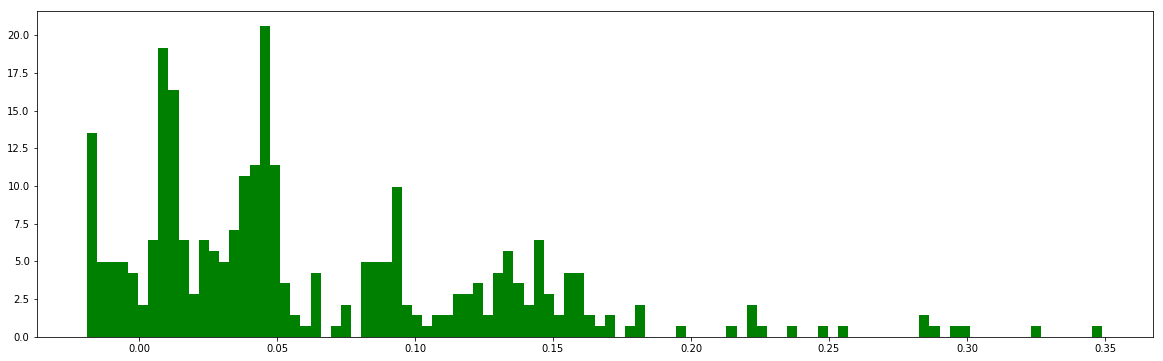

In [446]:
plt.figure(figsize=(20,6))
n, bins, patches = plt.hist(diff_gap_2_1, 100, normed=1, facecolor='green')

In [447]:
idxes_sorted = np.argsort(diff_gap_2_1)

In [448]:
idx = idxes_sorted[num_frames-1]
top_k = 5

print("Video name:")
print(video_name)
print("Frame id:")
frame_id = video_ids_s1[idx][1]+1
print(frame_id)

print("% of video:")
print(vid_id/num_frames)

print("\nGAP difference:")
print(diff_gap_2_1[idx])

print("\nGround truth:")
print(np.where(labels_s1[idx]>0)[0])
print("Stage 1:")
print(np.argsort(predictions_array_s1[idx])[::-1][:top_k])
print("Stage 2:")
print(np.argsort(predictions_array_s2[idx])[::-1][:top_k])

print("\nGround truth(s):")
for i in np.where(labels_s1[idx]>0)[0]:
    print("- " + labels_signification[i])
print("\nNo CRF:")
c = 0
for i in np.argsort(predictions_array_s1[idx])[::-1][:top_k]:
    print(str(c+1) + "." + labels_signification[i] + " - " + str(np.round(np.sort(predictions_array_s1[idx])[::-1][c],2)))
    c += 1

print("\nWith CRF:")
c = 0
for i in np.argsort(predictions_array_s2[idx])[::-1][:top_k]:
    print(str(c+1) + "." + labels_signification[i] + " - " + str(np.round(np.sort(predictions_array_s2[idx])[::-1][c],2)))
    c += 1

Video name:
6TC5G
Frame id:
100
% of video:
1.3368146214099217

GAP difference:
0.3488608418185883

Ground truth:
[  0   2   4  74  81 114]
Stage 1:
[113   8 112 114 141]
Stage 2:
[  0   1   4 114   2]

Ground truth(s):
- Holding some clothes
- Taking some clothes from somewhere
- Tidying some clothes
- Throwing a blanket somewhere
- Putting something on a shelf
- Tidying up a closet/cabinet

No CRF:
1.Opening a closet/cabinet - 0.29
2.Opening a door - 0.23
3.Closing a closet/cabinet - 0.16
4.Tidying up a closet/cabinet - 0.15
5.Grasping onto a doorknob - 0.14

With CRF:
1.Holding some clothes - 0.19
2.Putting clothes somewhere - 0.18
3.Tidying some clothes - 0.11
4.Tidying up a closet/cabinet - 0.11
5.Taking some clothes from somewhere - 0.11
